In [1]:
import sys
import os

#Use if working on Colab
#from google.colab import drive
#drive.mount('/content/drive')
#PATH = '/content/drive/My Drive/PPM_Stability/'

#If working locally
PATH = os.getcwd()
sys.path.append(PATH)

In [2]:
#!pip install --upgrade numpy

In [3]:
from DatasetManager import DatasetManager

import pandas as pd
import numpy as np

import os
import sys
from sys import argv
import pickle
import random
import joblib

from sklearn.metrics import accuracy_score
#import tensorflow as tf
#tf.keras.compat.disable_v2_backend()
from tensorflow.keras.backend import print_tensor
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, Flatten, Input
from keras.layers import LSTM
from keras.optimizers import Nadam, RMSprop
from tensorflow.keras.utils import plot_model
from keras.layers.normalization import BatchNormalization

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statistics
import math

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [4]:
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}


for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])
    print(dataset_manager.get_class_ratio(dataset_manager.read_dataset()))    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        if "single" in method:
            num_buckets = 1
        else:
            num_buckets = len([name for name in os.listdir(os.path.join(folder_loc,'models/'))])
            
        for bucket in range(num_buckets):
            if "lstm" in method:
                bucketID = "all"
            else:
                bucketID = bucket+1
            print ('Bucket', bucketID)
            
            X_train_path = os.path.join(folder_loc, "train_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)

            X_test_path = os.path.join(folder_loc, "test_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_test_path, 'rb') as f:
                dt_test_bucket = pickle.load(f)
            

            if "lstm" not in method: 
                y_train = dataset_manager.get_label_numeric(dt_train_bucket)
                y_test = dataset_manager.get_label_numeric(dt_test_bucket)
            
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                print("\tPositives in testing set:", test_pos_ratio)
                
                feat_comb_path = os.path.join(folder_loc, "bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (bucketID))
                with open (feat_comb_path, 'rb') as f:
                    feature_combiner = joblib.load(f)
                
                train_x = feature_combiner.transform(dt_train_bucket)
                test_x = feature_combiner.transform(dt_test_bucket)
                vector_length = test_x[0].shape
                
                print("Training instances:", len(y_train))
                print("Testing instances:", len(y_test))
                print("Feature Vector Length:", vector_length)
                
            else:
                y_train_path = os.path.join(folder_loc, "train_data/bucket_%s_labels.pickle" % (bucketID))
                with open (y_train_path, 'rb') as f:
                    train_y = pickle.load(f)

                y_test_path = os.path.join(folder_loc, "test_data/bucket_%s_labels.pickle" % (bucketID))
                with open (y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                
                y_train = [int(np.where(i==1)[0]) for i in train_y]
                y_test = test_y
               
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                print("\tPositives in testing set:", test_pos_ratio)
                
                vector_length = dt_test_bucket[0].shape
                
                print("Training instances:", len(y_train))
                print("Testing instances:", len(y_test))
                print("Feature Vector Length:", vector_length)

production
0.549618320610687
xgboost_single_agg
Bucket 1
	Positives in training set: 0.5886448848419925
	Positives in testing set: 0.36363636363636365
Training instances: 1867
Testing instances: 286
Feature Vector Length: (168,)
xgboost_prefix_agg
Bucket 1
	Positives in training set: 0.5984848484848485
	Positives in testing set: 0.4318181818181818
Training instances: 132
Testing instances: 88
Feature Vector Length: (146,)
Bucket 2
	Positives in training set: 0.6031746031746031
	Positives in testing set: 0.4523809523809524
Training instances: 126
Testing instances: 84
Feature Vector Length: (153,)
Bucket 3
	Positives in training set: 0.6083333333333333
	Positives in testing set: 0.46153846153846156
Training instances: 120
Testing instances: 78
Feature Vector Length: (150,)
Bucket 4
	Positives in training set: 0.5909090909090909
	Positives in testing set: 0.4411764705882353
Training instances: 110
Testing instances: 68
Feature Vector Length: (150,)
Bucket 5
	Positives in training set: 0.

Training instances: 9641
Testing instances: 2493
Feature Vector Length: (274,)
xgboost_prefix_agg
Bucket 1
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (192,)
Bucket 2
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (191,)
Bucket 3
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (197,)
Bucket 4
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (190,)
Bucket 5
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (195,)
Bucket 6
	Positives in training set: 0.1492776886035313
	Posit

Training instances: 152
Testing instances: 38
Feature Vector Length: (476,)
Bucket 19
	Positives in training set: 0.16541353383458646
	Positives in testing set: 0.05555555555555555
Training instances: 133
Testing instances: 36
Feature Vector Length: (471,)
Bucket 20
	Positives in training set: 0.18181818181818182
	Positives in testing set: 0.0625
Training instances: 121
Testing instances: 32
Feature Vector Length: (506,)
Bucket 21
	Positives in training set: 0.18181818181818182
	Positives in testing set: 0.07142857142857142
Training instances: 99
Testing instances: 28
Feature Vector Length: (505,)
Bucket 22
	Positives in training set: 0.16470588235294117
	Positives in testing set: 0.08333333333333333
Training instances: 85
Testing instances: 24
Feature Vector Length: (484,)
Bucket 23
	Positives in training set: 0.17105263157894737
	Positives in testing set: 0.09523809523809523
Training instances: 76
Testing instances: 21
Feature Vector Length: (503,)
Bucket 24
	Positives in training se

Training instances: 1764
Testing instances: 483
Feature Vector Length: (134,)
Bucket 35
	Positives in training set: 0.5908267954133977
	Positives in testing set: 0.6592920353982301
Training instances: 1657
Testing instances: 452
Feature Vector Length: (134,)
Bucket 36
	Positives in training set: 0.5957988542329726
	Positives in testing set: 0.6839622641509434
Training instances: 1571
Testing instances: 424
Feature Vector Length: (134,)
Bucket 37
	Positives in training set: 0.596244131455399
	Positives in testing set: 0.6842105263157895
Training instances: 1491
Testing instances: 399
Feature Vector Length: (134,)
Bucket 38
	Positives in training set: 0.6071932299012694
	Positives in testing set: 0.6832460732984293
Training instances: 1418
Testing instances: 382
Feature Vector Length: (134,)
Bucket 39
	Positives in training set: 0.6067924528301887
	Positives in testing set: 0.6940509915014165
Training instances: 1325
Testing instances: 353
Feature Vector Length: (134,)
Bucket 40
	Positiv

Training instances: 1253
Testing instances: 337
Feature Vector Length: (2829,)


production
xgboost_single_agg
Bucket 1


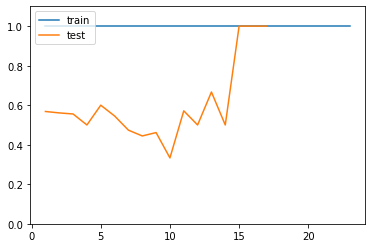

	Training accuracy: 1.0
		Training accuracy - Positives: 1.0
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.541958041958042
		Testing accuracy - Positives: 0.4262295081967213
		Testing accuracy - Negatives: 0.7475728155339806
xgboost_prefix_agg
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23


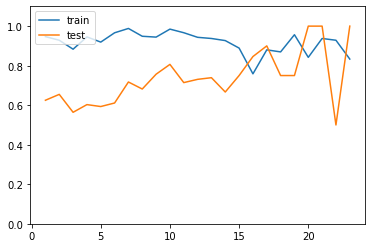

	Training accuracy: 0.9324127906976745
		Training accuracy - Positives: 1.0
		Training accuracy - Negatives: 0.8590909090909091
	Testing accuracy: 0.6706192358366272
		Testing accuracy - Positives: 0.6306068601583114
		Testing accuracy - Negatives: 0.7105263157894737
xgboost_prefix_index
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23


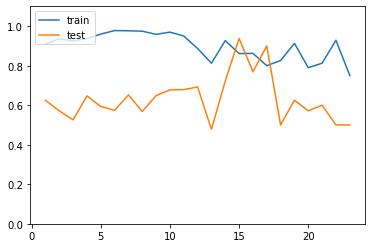

	Training accuracy: 0.9251453488372093
		Training accuracy - Positives: 0.998587570621469
		Training accuracy - Negatives: 0.8473053892215568
	Testing accuracy: 0.6179183135704874
		Testing accuracy - Positives: 0.594855305466238
		Testing accuracy - Negatives: 0.6339285714285714
sepsis_cases
xgboost_single_agg
Bucket 1


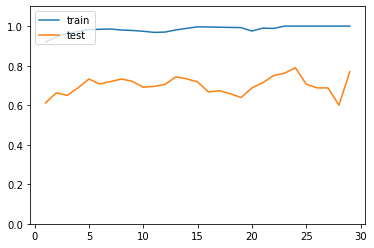

	Training accuracy: 0.9742765273311897
		Training accuracy - Positives: 0.8611422172452408
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.6967509025270758
		Testing accuracy - Positives: 0.08967851099830795
		Testing accuracy - Negatives: 0.8853838065194533
xgboost_prefix_agg
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23
Bucket 24
Bucket 25
Bucket 26
Bucket 27
Bucket 28
Bucket 29


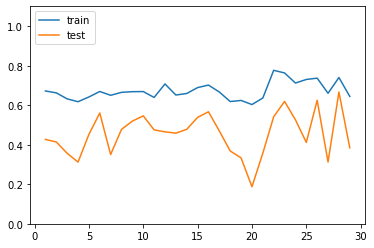

	Training accuracy: 0.6607198423400062
		Training accuracy - Positives: 0.31981700977334165
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.45046129161652626
		Testing accuracy - Positives: 0.09144981412639405
		Testing accuracy - Negatives: 0.8710801393728222
xgboost_prefix_index
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23
Bucket 24
Bucket 25
Bucket 26
Bucket 27
Bucket 28
Bucket 29


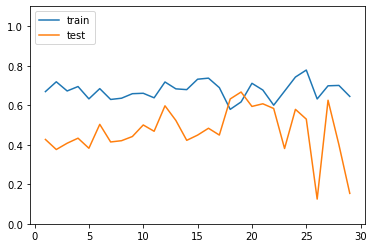

	Training accuracy: 0.6712996577118556
		Training accuracy - Positives: 0.3267473974930954
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.45808263136782995
		Testing accuracy - Positives: 0.09337349397590361
		Testing accuracy - Negatives: 0.8738197424892704
bpic2012
xgboost_single_agg
Bucket 1


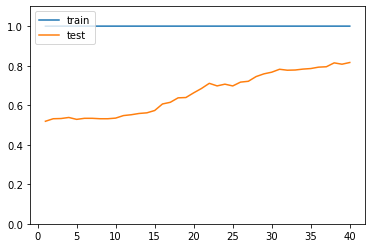

	Training accuracy: 0.9999915229093375
		Training accuracy - Positives: 0.9999830821025563
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.6342004765479649
		Testing accuracy - Positives: 0.6842946668371914
		Testing accuracy - Negatives: 0.5819721314754317
xgboost_prefix_agg
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23
Bucket 24
Bucket 25
Bucket 26
Bucket 27
Bucket 28
Bucket 29
Bucket 30
Bucket 31
Bucket 32
Bucket 33
Bucket 34
Bucket 35
Bucket 36
Bucket 37
Bucket 38
Bucket 39
Bucket 40


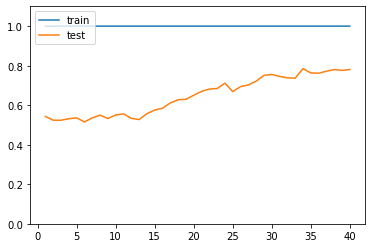

	Training accuracy: 0.999983045818675
		Training accuracy - Positives: 1.0
		Training accuracy - Negatives: 0.9999660204896448
	Testing accuracy: 0.6237882299180729
		Testing accuracy - Positives: 0.6672194582642343
		Testing accuracy - Negatives: 0.5745332961827807
xgboost_prefix_index
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23
Bucket 24
Bucket 25
Bucket 26
Bucket 27
Bucket 28
Bucket 29
Bucket 30
Bucket 31
Bucket 32
Bucket 33
Bucket 34
Bucket 35
Bucket 36
Bucket 37
Bucket 38
Bucket 39
Bucket 40


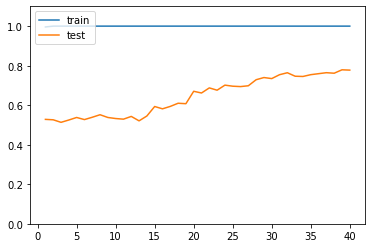

	Training accuracy: 0.9998643665494003
		Training accuracy - Positives: 0.9998139188686267
		Training accuracy - Negatives: 0.9999150396764711
	Testing accuracy: 0.620556843032934
		Testing accuracy - Positives: 0.6714340687532068
		Testing accuracy - Negatives: 0.5678298438019276


In [5]:
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
titles = {"production": "Production: ", "sepsis_cases": "Sepsis Cases: ", "bpic2012": "BPIC2012: ",
         "xgboost_single_agg": "Single Bucket & Aggregate Encoding", "xgboost_prefix_agg": "Prefix-Length Buckets \n& Aggregate Encoding",
         "xgboost_prefix_index": "Prefix-Length Buckets \n& Index-Based Encoding"}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        if "single" in method:
            num_buckets = 1
        else:
            num_buckets = len([name for name in os.listdir(os.path.join(folder_loc,'models/'))])
            
        train_lengths = []
        train_predictions = []
        train_y_all = []
        
        test_lengths = []
        test_predictions = []
        test_y_all = []
            
        for bucket in range(num_buckets):
            if "lstm" in method:
                bucketID = "all"
            else:
                bucketID = bucket+1
            print ('Bucket', bucketID)
            
            X_train_path = os.path.join(folder_loc, "train_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)

            X_test_path = os.path.join(folder_loc, "test_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_test_path, 'rb') as f:
                dt_test_bucket = pickle.load(f)
            

            if "lstm" not in method: 
                y_train = dataset_manager.get_label_numeric(dt_train_bucket)
                y_test = dataset_manager.get_label_numeric(dt_test_bucket)
            
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                #print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                #print("\tPositives in testing set:", test_pos_ratio)
                
                pipeline_path = os.path.join(folder_loc, "pipelines/pipeline_bucket_%s.joblib" % (bucketID))
                with open (pipeline_path, 'rb') as f:
                    pipeline = joblib.load(f)
                
                prefix_lengths = dataset_manager.get_prefix_lengths(dt_train_bucket)             
                train_lengths.extend(prefix_lengths.values)
                
                prefix_lengths = dataset_manager.get_prefix_lengths(dt_test_bucket)             
                test_lengths.extend(prefix_lengths.values)
                
                train_preds = pipeline.predict(dt_train_bucket)
                train_predictions.extend(train_preds)
                
                test_preds = pipeline.predict(dt_test_bucket)
                test_predictions.extend(test_preds)
                
                train_y_all.extend(y_train)
                test_y_all.extend(y_test)
            
        lens = list(set(train_lengths))
        train_accs = []
        test_accs = []
        for i in lens:
            idxs = [n for n in range(len(train_lengths)) if train_lengths[n] == i]
            preds = [train_predictions[n] for n in idxs]
            actual = [train_y_all[n] for n in idxs]
            accuracy = accuracy_score(actual, preds)
            train_accs.append(accuracy)
            
            idxs = [n for n in range(len(test_lengths)) if test_lengths[n] == i]
            preds = [test_predictions[n] for n in idxs]
            actual = [test_y_all[n] for n in idxs]
            accuracy = accuracy_score(actual, preds)
            test_accs.append(accuracy)


        plt.plot(lens, train_accs, label = 'train')#, color = 'black')
        plt.plot(lens, test_accs, label = 'test')#, color = 'grey')
        plt.legend(loc = "upper left")
        plt.ylim(0,1.1)
        #plt.title(titles[data]+titles[method])
        plt.show()
        
        train_acc = accuracy_score(train_y_all, train_predictions)
        print("\tTraining accuracy:", train_acc)
        
        train_pos_idx = [i for i in range(len(train_predictions)) if train_predictions[i] == 1]
        actual = [train_y_all[i] for i in train_pos_idx]
        preds = [train_predictions[i] for i in train_pos_idx]
        train_pos_acc = accuracy_score(actual, preds)
        print("\t\tTraining accuracy - Positives:", train_pos_acc)
        
        train_neg_idx = [i for i in range(len(train_predictions)) if train_predictions[i] == 0]
        actual = [train_y_all[i] for i in train_neg_idx]
        preds = [train_predictions[i] for i in train_neg_idx]
        train_neg_acc = accuracy_score(actual, preds)
        print("\t\tTraining accuracy - Negatives:", train_neg_acc)
        
        test_acc = accuracy_score(test_y_all, test_predictions)
        print("\tTesting accuracy:", test_acc)
        
        test_pos_idx = [i for i in range(len(test_predictions)) if test_predictions[i] == 1]
        actual = [test_y_all[i] for i in test_pos_idx]
        preds = [test_predictions[i] for i in test_pos_idx]
        test_pos_acc = accuracy_score(actual, preds)
        print("\t\tTesting accuracy - Positives:", test_pos_acc)
        
        test_neg_idx = [i for i in range(len(test_predictions)) if test_predictions[i] == 0]
        actual = [test_y_all[i] for i in test_neg_idx]
        preds = [test_predictions[i] for i in test_neg_idx]
        test_neg_acc = accuracy_score(actual, preds)
        print("\t\tTesting accuracy - Negatives:", test_neg_acc)
            
        #break
                

production
xgboost_single_agg
xgboost_prefix_agg
xgboost_prefix_index
sepsis_cases
xgboost_single_agg
xgboost_prefix_agg
xgboost_prefix_index
bpic2012
xgboost_single_agg
xgboost_prefix_agg
xgboost_prefix_index


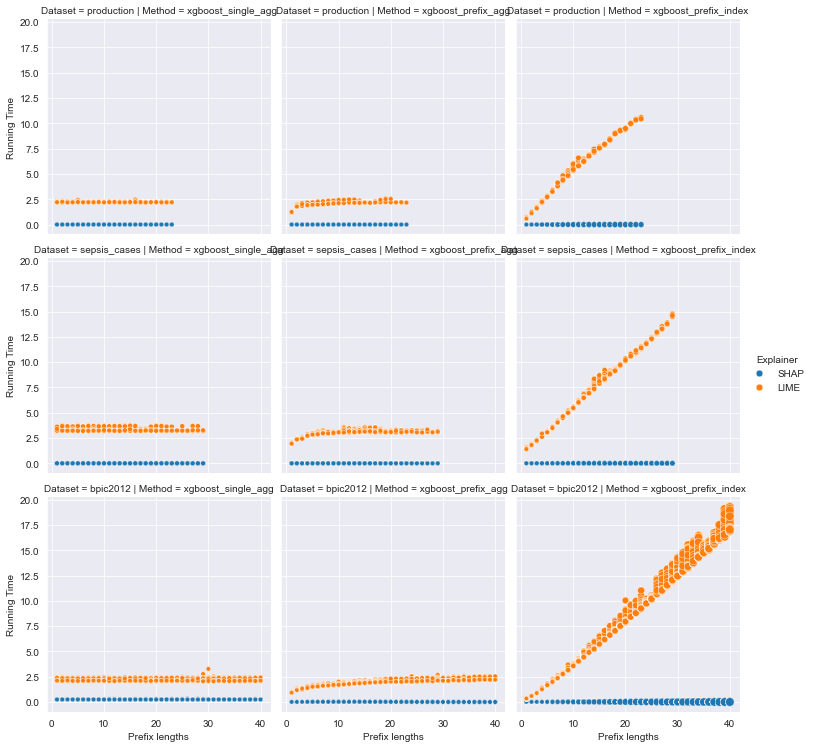

In [20]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_feat_lens = []
all_explainers = []
all_times = []
all_datasets = []
all_methods = []

data_dict = {"Prefix lengths": all_pref_lens, "Feature vector sizes": all_feat_lens, "Explainer": all_explainers,
       "Running time": all_times, "Dataset": all_datasets, "Method": all_methods}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        all_timing_path = os.path.join(folder_loc, "all_timing.csv")
        all_data = pd.read_csv(all_timing_path)
        
        all_pref_lens.extend(pd.Series(all_data['Prefix Length']))
        all_feat_lens.extend(pd.Series(all_data['Feature Vector Length']))
        all_explainers.extend(pd.Series(all_data['Explainer']))
        all_times.extend(pd.Series(all_data['Running Time']))
        
        all_datasets.extend([data]*all_data.shape[0])
        all_methods.extend([method]*all_data.shape[0])
        
comb_data = pd.DataFrame(data_dict)
sns.set_style('darkgrid')
grid = sns.FacetGrid(comb_data, row = 'Dataset', col = 'Method', hue = 'Explainer', 
                     legend_out = True, height = 3.5, aspect = 1)
grid.map(sns.scatterplot, "Prefix lengths", "Running time", size= comb_data["Feature vector sizes"])
grid.set_axis_labels("Prefix lengths", "Running Time")
grid.add_legend()
plt.show()

In [28]:
size_dict = {}
for data in datasets:
    size_dict[data] = {}
    data_data = comb_data[comb_data['Dataset'] == data]
    for each in methods:
        size_dict[data][each] = {}
        method_data = data_data[data_data['Method'] == each]
        keys = [str(i) for i in method_data['Prefix lengths'].unique()]
        for key in keys:
            length = [i for i in method_data[method_data['Prefix lengths'] == int(key)]['Feature vector sizes']][0]
            size_dict[data][each][key] = length

production
xgboost_single_agg


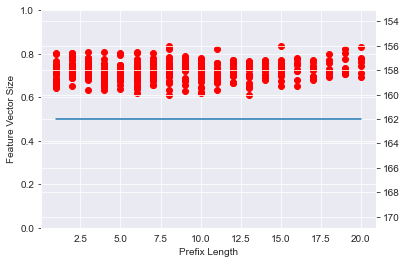

LIME: 0.7214615891743864
SHAP: nan
xgboost_prefix_agg


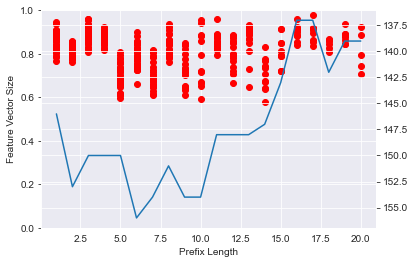

LIME: 0.8142825714456351
SHAP: nan
xgboost_prefix_index


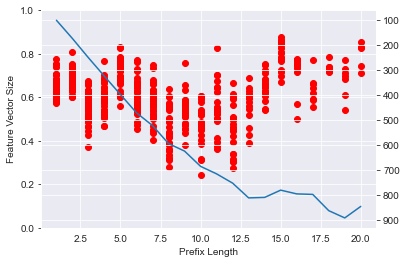

LIME: 0.6014391437124833
SHAP: nan
sepsis_cases
xgboost_single_agg


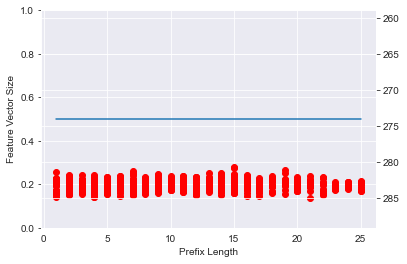

LIME: 0.19790073718979145
SHAP: nan
xgboost_prefix_agg


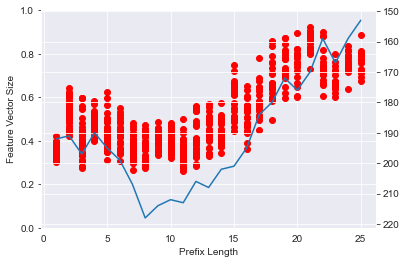

LIME: 0.5027231572337247
SHAP: nan
xgboost_prefix_index


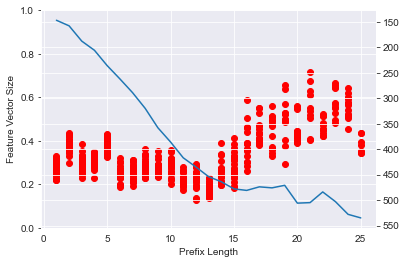

LIME: 0.32733943486231054
SHAP: nan
bpic2012
xgboost_single_agg


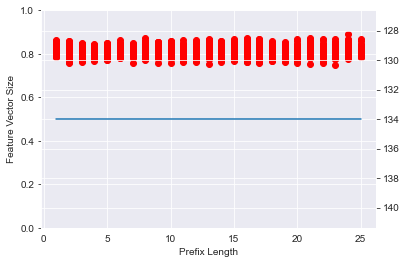

LIME: 0.8146213261648745
SHAP: nan
xgboost_prefix_agg


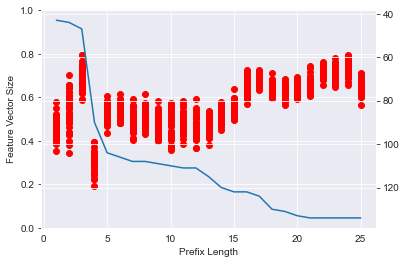

LIME: 0.5675298744489482
SHAP: nan
xgboost_prefix_index


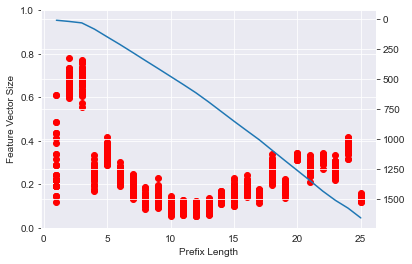

LIME: 0.24222560122517695
SHAP: nan


In [32]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_feat_vec = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens, 'Feature Vector Sizes': all_feat_vec}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        feat_vec = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
                
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['lime_stability'])
                #bucket_tree_shap_stability = pd.Series(results['tree_shap_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                #tree_shap_stability.extend(bucket_tree_shap_stability)
                
        for length in nr_events:
            feat_vec.append(size_dict[data][method][str(length)])
        
        plot_lens = list(set(nr_events))
        plot_vecs = [size_dict[data][method][str(i)] for i in plot_lens]
        
        fig, ax = plt.subplots()
        ax.plot(nr_events, lime_stability, 'ro', label = "LIME")
        ax2 = ax.twinx()
        ax2.plot(plot_lens, plot_vecs, label = "Feature Vector")
        ax.set_xlabel("Prefix Length")
        ax.set_ylabel("Stability")
        ax.set_ylabel("Feature Vector Size")
        ax.set_ylim(0, 1)
        ax2.invert_yaxis()
        plt.show()
        
        
        #for i in range(2):
        all_pref_lens.extend(nr_events)
        all_proba.extend(proba)
        all_datasets.extend([data]*len(nr_events))
        all_methods.extend([method]*len(nr_events))
        all_feat_vec.extend(feat_vec)

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))
        
        all_stability.extend(lime_stability)
        all_stability.extend(tree_shap_stability)
            
        avg_lime_stability = np.mean(lime_stability)
        avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
        print("SHAP:", avg_shap_stability)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])

production
xgboost_single_agg
LIME: 0.7214615891743864
SHAP: 1.0
xgboost_prefix_agg
LIME: 0.8142825714456351
SHAP: 1.0
xgboost_prefix_index
LIME: 0.6014391437124833
SHAP: 1.0
sepsis_cases
xgboost_single_agg
LIME: 0.19790073718979145
SHAP: 1.0
xgboost_prefix_agg
LIME: 0.5027231572337247
SHAP: 1.0
xgboost_prefix_index
LIME: 0.32733943486231054
SHAP: 1.0
bpic2012
xgboost_single_agg
LIME: 0.8146213261648745
SHAP: 1.0
xgboost_prefix_agg
LIME: 0.5675298744489482
SHAP: 1.0
xgboost_prefix_index
LIME: 0.24222560122517695
SHAP: 1.0


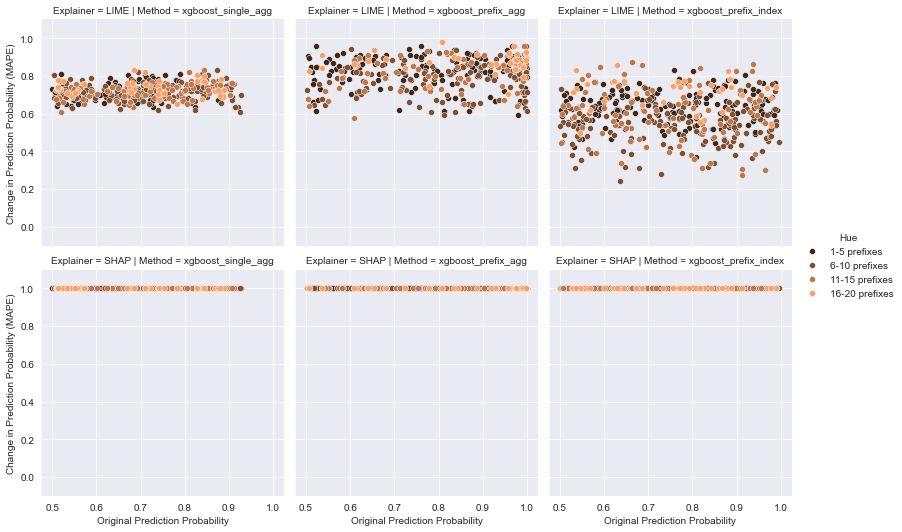

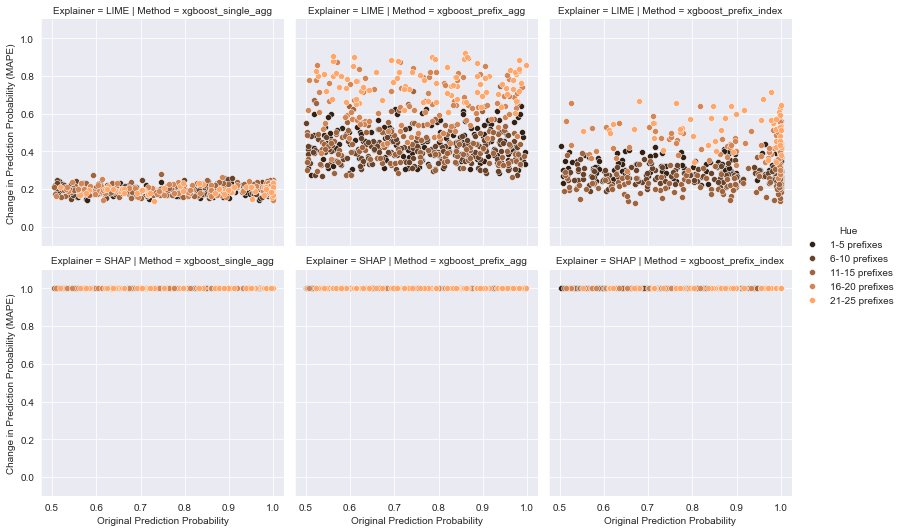

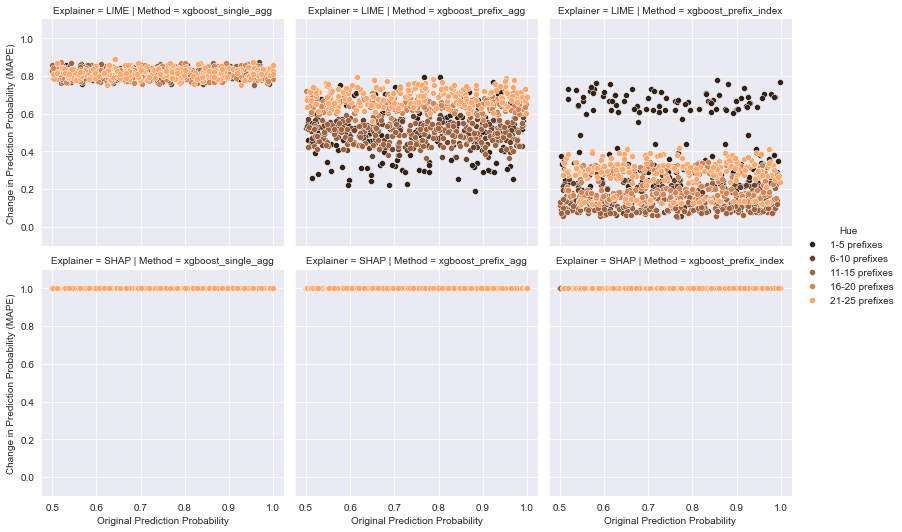

In [35]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['lime_stability'])
                bucket_tree_shap_stability = pd.Series(results['tree_shap_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                tree_shap_stability.extend(bucket_tree_shap_stability)
                
        for i in range(2):
            all_pref_lens.extend(nr_events)
            all_proba.extend(proba)
            all_datasets.extend([data]*len(nr_events))
            all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))
        
        all_stability.extend(lime_stability)
        all_stability.extend(tree_shap_stability)
            
        avg_lime_stability = np.mean(lime_stability)
        avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
        print("SHAP:", avg_shap_stability)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)
comb_data = comb_data.sort_values(['Prefix lengths', 'Explainer'])

sns.set_style('darkgrid')
# grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', hue = 'Hue', 
#                      legend_out = True, height = 4, aspect = 1, palette = 'copper', ylim = (-1.1, 1.1))
# grid.map(sns.scatterplot, "Prediction Probability", "Stability")
# grid.set_axis_labels("Prediction Probability", "Stability")
# grid.add_legend()
# plt.show()

for data in datasets:
    data_fid = comb_data[comb_data["Dataset"] == data]
    data_fid = data_fid.sort_values(['Prefix lengths', 'Explainer'])
    #data_fid = data_fid.sort_values('Method', ascending = False)
    
    sns.set_style('darkgrid')
    grid = sns.FacetGrid(data_fid, col = 'Method', row = 'Explainer', hue = 'Hue', 
                         legend_out = True, height = 3.75, aspect = 1, palette = 'copper', ylim = (-0.1, 1.1))
    grid.map(sns.scatterplot, "Prediction Probability", "Stability")
    grid.set_axis_labels("Original Prediction Probability", "Stability")
    grid.add_legend()
    plt.show()

production
xgboost_single_agg
LIME: 0.9484885858512437
SHAP: 1.0
xgboost_prefix_agg
LIME: 0.886484291626052
SHAP: 0.9999999999999999
xgboost_prefix_index
LIME: 0.7984736886684136
SHAP: 1.0
sepsis_cases
xgboost_single_agg
LIME: 0.3554187240876852
SHAP: 0.9999999999999998
xgboost_prefix_agg
LIME: 0.6332039517834133
SHAP: 1.0
xgboost_prefix_index
LIME: -0.036321732883597115
SHAP: 1.0
bpic2012
xgboost_single_agg
LIME: 0.8546317075472512
SHAP: 1.0
xgboost_prefix_agg
LIME: 0.6666338260750934
SHAP: 1.0
xgboost_prefix_index
LIME: 0.29974142977902074
SHAP: 1.0


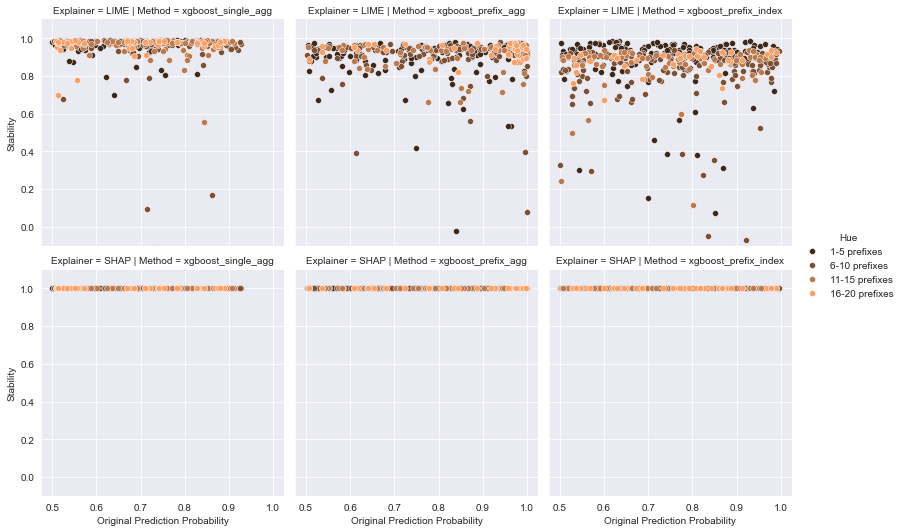

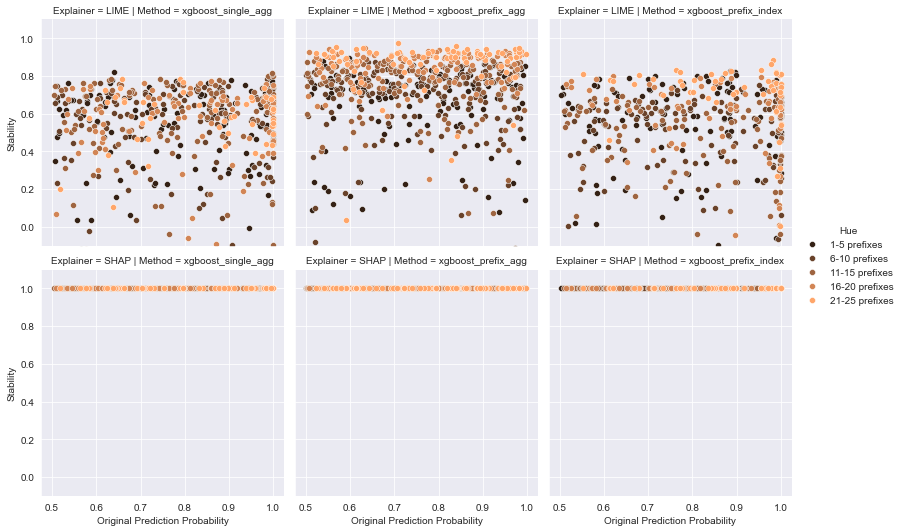

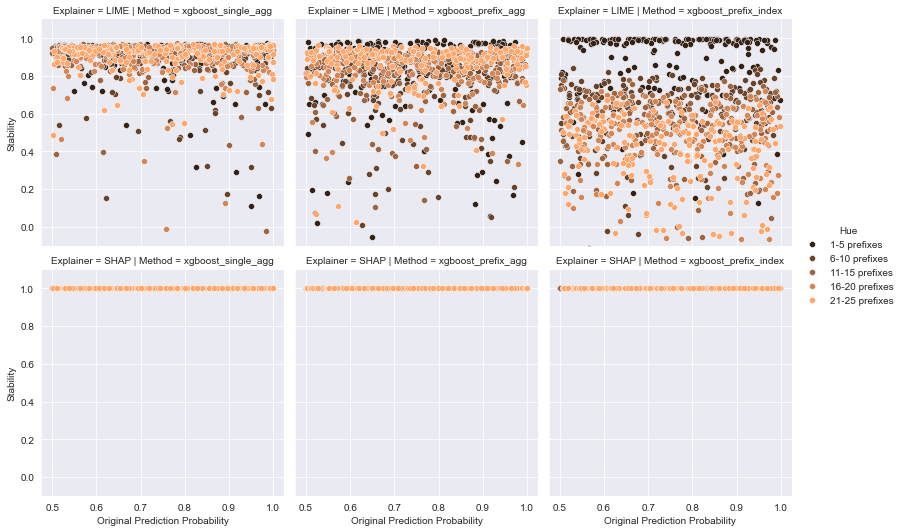

In [38]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['adjusted_lime_importance_stability'])
                bucket_tree_shap_stability = pd.Series(results['adjusted_shap_importance_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                tree_shap_stability.extend(bucket_tree_shap_stability)
                
        for i in range(2):
            all_pref_lens.extend(nr_events)
            all_proba.extend(proba)
            all_datasets.extend([data]*len(nr_events))
            all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))

        all_stability.extend(lime_stability)
        all_stability.extend(tree_shap_stability)

        avg_lime_stability = np.mean(lime_stability)
        avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
        print("SHAP:", avg_shap_stability)

max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)
#comb_data = comb_data.sort_values('Method', ascending = False)
comb_data = comb_data.sort_values(['Prefix lengths', 'Explainer'])

sns.set_style('darkgrid')
# grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', hue = 'Hue', 
#                      legend_out = True, height = 4, aspect = 1, palette = 'copper', ylim = (-1.1, 1.1))
# grid.map(sns.scatterplot, "Prediction Probability", "Stability")
# grid.set_axis_labels("Prediction Probability", "Stability")
# grid.add_legend()
# plt.show()

for data in datasets:
    data_fid = comb_data[comb_data["Dataset"] == data]
    data_fid = data_fid.sort_values(['Prefix lengths', 'Explainer'])
    #data_fid = data_fid.sort_values('Method', ascending = False)
    
    sns.set_style('darkgrid')
    grid = sns.FacetGrid(data_fid, col = 'Method', row = 'Explainer', hue = 'Hue', 
                         legend_out = True, height = 3.75, aspect = 1, palette = 'copper', ylim = (-0.1, 1.1))
    grid.map(sns.scatterplot, "Prediction Probability", "Stability")
    grid.set_axis_labels("Original Prediction Probability", "Stability")
    grid.add_legend()
    plt.show()

production
xgboost_single_agg
LIME: 0.2604979788542514
SHAP: 0.27469174680679204
xgboost_prefix_agg
LIME: 0.47366466356136006
SHAP: 0.5089115965891036
xgboost_prefix_index
LIME: 0.3585034241195877
SHAP: 0.5103312369683687
sepsis_cases
xgboost_single_agg
LIME: 0.35960311142519635
SHAP: 0.46027759028983267
xgboost_prefix_agg
LIME: 0.3744494652066537
SHAP: 0.4878459323145076
xgboost_prefix_index
LIME: 0.514911224795386
SHAP: 0.5632143593134832
bpic2012
xgboost_single_agg
LIME: 0.37220934358942104
SHAP: 0.41453806470687543
xgboost_prefix_agg
LIME: 0.3785738615379294
SHAP: 0.4164828308584071
xgboost_prefix_index
LIME: 0.316491232210647
SHAP: 0.3977022960252316


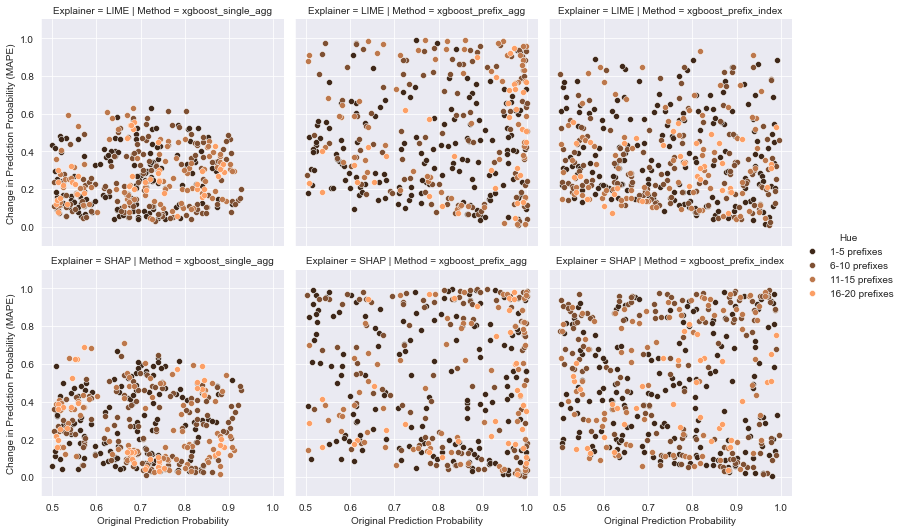

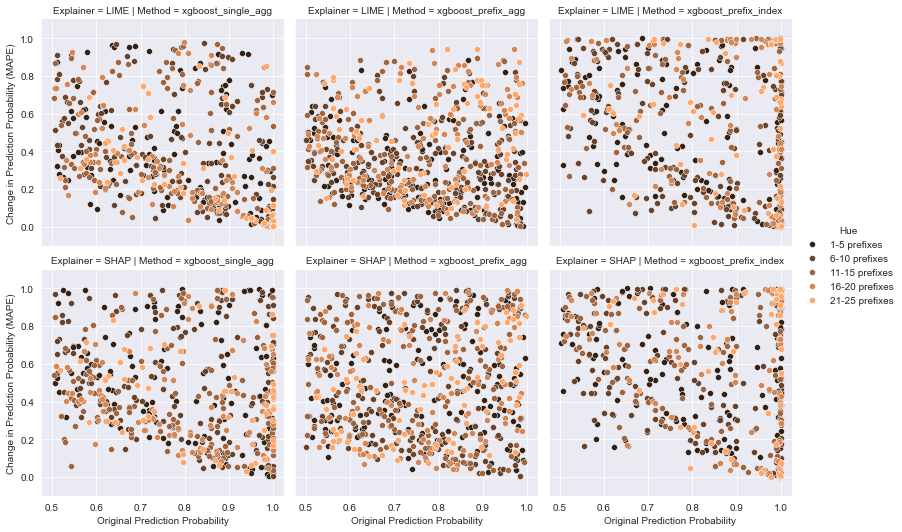

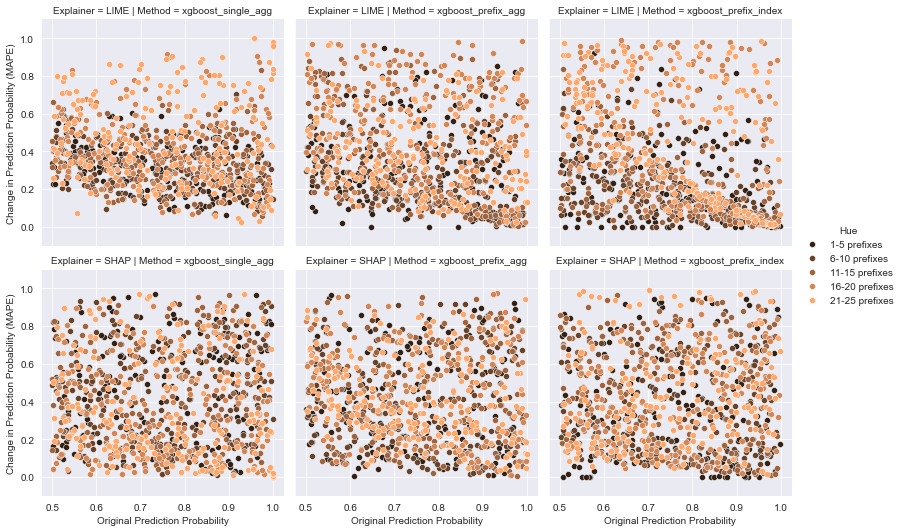

In [39]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
#methods = ["xgboost_prefix_index"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_fidelity = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Fidelity": all_fidelity, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_fidelity = []
        tree_shap_fidelity = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                lime_diffs = pd.Series(results['lime_fid_change'])
                shap_diffs = pd.Series(results['shap_fid_change'])
                
                lime_mape = []
                shap_mape = []
                
                for j in range(len(lime_diffs)):
                    p1 = bucket_proba[j]
                    
                    lime_diff = lime_diffs[j]
                    shap_diff = shap_diffs[j]
                                        
                    lime_rel_changes = []
                    shap_rel_changes = []
                    
                    for each in lime_diff:
                        lime_rel_changes.append(abs(each)/p1)
                        
                    for each in shap_diff:
                        shap_rel_changes.append(abs(each)/p1)
                    
                    lime_mape.append(sum(lime_rel_changes)/len(lime_rel_changes))
                    shap_mape.append(sum(shap_rel_changes)/len(shap_rel_changes))

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_fidelity.extend(lime_mape)
                tree_shap_fidelity.extend(shap_mape)
                
        for i in range(2):
            all_pref_lens.extend(nr_events)
            all_proba.extend(proba)
            all_datasets.extend([data]*len(nr_events))
            all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))

        all_fidelity.extend(lime_fidelity)
        all_fidelity.extend(tree_shap_fidelity)

        avg_lime_fidelity = np.mean(lime_fidelity)
        avg_shap_fidelity = np.mean(tree_shap_fidelity)

        print("LIME:", avg_lime_fidelity)
        print("SHAP:", avg_shap_fidelity)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)

sns.set_style('darkgrid')
# grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', hue = 'Hue', 
#                      legend_out = True, height = 4, aspect = 1, palette = 'copper', ylim = (-1.1, 1.1))
# grid.map(sns.scatterplot, "Prediction Probability", "Stability")
# grid.set_axis_labels("Prediction Probability", "Stability")
# grid.add_legend()
plt.show()

for data in datasets:
    data_fid = comb_data[comb_data["Dataset"] == data]
    data_fid = data_fid.sort_values(['Prefix lengths', 'Explainer'])
    #data_fid = data_fid.sort_values('Method', ascending = False)
    
    sns.set_style('darkgrid')
    grid = sns.FacetGrid(data_fid, col = 'Method', row = 'Explainer', hue = 'Hue', 
                         legend_out = True, height = 3.75, aspect = 1, palette = 'copper', ylim = (-0.1, 1.1))
    grid.map(sns.scatterplot, "Prediction Probability", "Fidelity")
    grid.set_axis_labels("Original Prediction Probability", "Change in Prediction Probability (MAPE)")
    grid.add_legend()
    plt.show()